# RQ4: How frequently do developers use the conversion functions?


## Data Preparation

In [77]:
from pathlib import Path

import pandas as pd
# extracted compressed results
!unzip -o ../../data/sfconvertbot_pr_metadata.csv.zip -d ../../data
# Load the dataset
df = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
print("Number of PRs: ", len(df))

# remove rows with missing values
df = df.dropna()
print("Number of PRs after removing missing values: ", len(df))

# remove rows with invalid JSONs
df = df[df['discussion_metadata'].str.startswith('{')]
print("Number of PRs after removing invalid JSONs: ", len(df))

# add a date column
df['date'] = df['time'].str.split('T').str[0]
df['date'] = df['date'].str.split(' ').str[0]
# ensure date column is a datetime object
df['date'] = pd.to_datetime(df['date'])
# filter in place, keep only commits before Oct 31 2024 (including)
df = df[df['date'] <= pd.Timestamp(2024, 10, 31)]
print("Number of PRs after filtering by date: ", len(df))

# remove the extracted zip file
!rm ../../data/sfconvertbot_pr_metadata.csv

Archive:  ../../data/sfconvertbot_pr_metadata.csv.zip
  inflating: ../../data/sfconvertbot_pr_metadata.csv  
Number of PRs:  45394
Number of PRs after removing missing values:  45311
Number of PRs after removing invalid JSONs:  45307
Number of PRs after filtering by date:  45072


## Extracting PR Statuses


In [87]:
from tqdm import tqdm
import json


def label_status(row: pd.Series) -> str:
    # check if the PR has conflicts
    if row['conflicts']:
        return f"{row['status']} (has conflicts)"
    return row['status']
    
    

# Extract status changes from discussion metadata
for index, row in tqdm(df.iterrows(), total=len(df)):
    # add a column to track status changes
    status_changes = []
    discussion = json.loads(row['discussion_metadata'])['discussion']
    for event in discussion['events']:
        event_type = event['type']
        if event_type == 'status-change':
            status_changes.append(event['data']['status'])
    
    
    df.at[index, 'status_changes'] = ";".join(status_changes)
    
    # add a column to track files with conflicts
    df.at[index, 'conflicts'] = ""
    header = json.loads(row['header_metadata'])
    df.at[index, 'status'] = header['discussion']['status']
    # check if there are conflicting files
    conflicting_files = header['discussion'].get('filesWithConflicts', [])
    df.at[index, 'conflicts'] = ";".join(conflicting_files)
    
    # adjust the status
    df.at[index, 'status'] = label_status(df.loc[index])
    
df


100%|██████████| 45072/45072 [00:14<00:00, 3142.92it/s]


,pr_url,discussion_metadata,header_metadata,model_id,time,date,conflicts,status,status_changes
235,https://huggingface.co/osunlp/attrscore-flan-t...,"{""apiBaseUrl"":""/api/models/osunlp/attrscore-fl...","{""discussion"":{""_id"":""6724172b01dfe1d1b6cd8079...",osunlp/attrscore-flan-t5-xl,2024-10-31T23:47:55.000Z,2024-10-31,,open,
236,https://huggingface.co/Dheeraj46329/llama-3.2-...,"{""apiBaseUrl"":""/api/models/Dheeraj46329/llama-...","{""discussion"":{""_id"":""6724157c708f76fcb90337b6...",Dheeraj46329/llama-3.2-new-22-0.5-3e,2024-10-31T23:40:44.000Z,2024-10-31,,merged,merged
237,https://huggingface.co/Dheeraj46329/llama-3.2-...,"{""apiBaseUrl"":""/api/models/Dheeraj46329/llama-...","{""discussion"":{""_id"":""67241365d31bd8b04d8532e8...",Dheeraj46329/llama-3.2-new-26-0.5-3e,2024-10-31T23:31:49.000Z,2024-10-31,,merged,merged
238,https://huggingface.co/BAAI/Emu2/discussions/4...,"{""apiBaseUrl"":""/api/models/BAAI/Emu2"",""current...","{""discussion"":{""_id"":""6724120a93b72c9eaf2fadc6...",BAAI/Emu2,2024-10-31T23:26:02.000Z,2024-10-31,,open,
239,https://huggingface.co/royweiss1/T5_MiddleSent...,"{""apiBaseUrl"":""/api/models/royweiss1/T5_Middle...","{""discussion"":{""_id"":""6724101f1fc6d46db5cce1b6...",royweiss1/T5_MiddleSentences,2024-10-31T23:17:51.000Z,2024-10-31,,open,
...,...,...,...,...,...,...,...,...,...
45389,https://huggingface.co/cahya/bert-base-indones...,"{""apiBaseUrl"":""/api/models/cahya/bert-base-ind...","{""discussion"":{""_id"":""641337164c23691ebe156b98...",cahya/bert-base-indonesian-NER,2023-03-16 16:34:48.663142,2023-03-16,,open,
45390,https://huggingface.co/NonzeroCornet34/DialoGP...,"{""apiBaseUrl"":""/api/models/NonzeroCornet34/Dia...","{""discussion"":{""_id"":""641337145e06fbbe23a0f1c7...",NonzeroCornet34/DialoGPT-small-philbot,2023-03-16 16:34:46.516709,2023-03-16,,open,
45391,https://huggingface.co/uer/chinese_roberta_L-1...,"{""apiBaseUrl"":""/api/models/uer/chinese_roberta...","{""discussion"":{""_id"":""6413371374a580779ac98717...",uer/chinese_roberta_L-12_H-768,2023-03-16 16:34:46.082500,2023-03-16,,open,
45392,https://huggingface.co/Narsil/finbert2/discuss...,"{""apiBaseUrl"":""/api/models/Narsil/finbert2"",""c...","{""discussion"":{""_id"":""641337045e06fbbe23a0ed64...",Narsil/finbert2,2023-03-16 16:34:30.349179,2023-03-16,,closed,closed


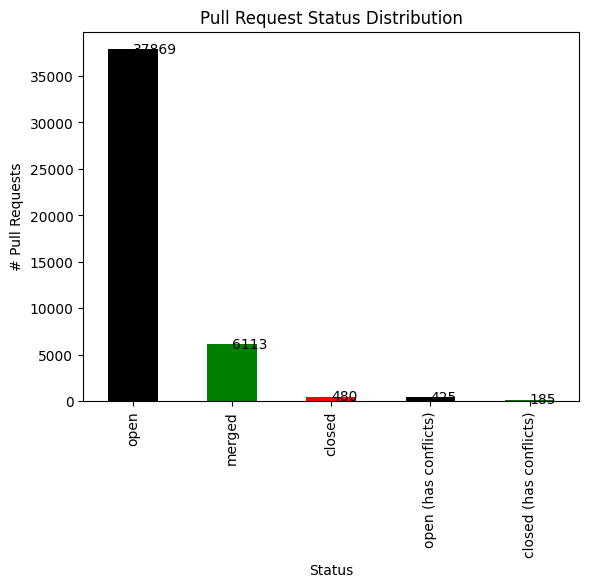

<Axes: ylabel='count'>

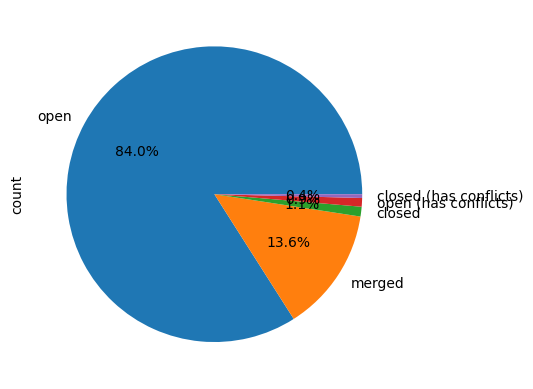

In [106]:

import matplotlib.pyplot as plt

status_distribution = df['status'].value_counts()
# Plot the status distribution horizontally
status_distribution.plot(kind='bar', color=['black', 'green', 'red'])
# add data labels
for i, v in enumerate(status_distribution):
    plt.text(i, v, str(v), color='black', va='center')

# Add title and labels
plt.title('Pull Request Status Distribution')
plt.xlabel('Status')
plt.ylabel('# Pull Requests')
plt.show()

# show pie chart
status_distribution.plot.pie(autopct='%1.1f%%')

In [116]:
import matplotlib.pyplot as plt

# Calculate the status distribution and convert to DataFrame
status_distribution = df['status'].value_counts().reset_index()
status_distribution.columns = ['status', 'count']

# Sort by status alphabetically, then by count
status_distribution = status_distribution.sort_values(by=['status', 'count'], ascending=[True, False])

# Convert back to Series for plotting
status_distribution = status_distribution.set_index('status')['count']


status_distribution

status
closed                      480
closed (has conflicts)      185
merged                     6113
open                      37869
open (has conflicts)        425
Name: count, dtype: int64

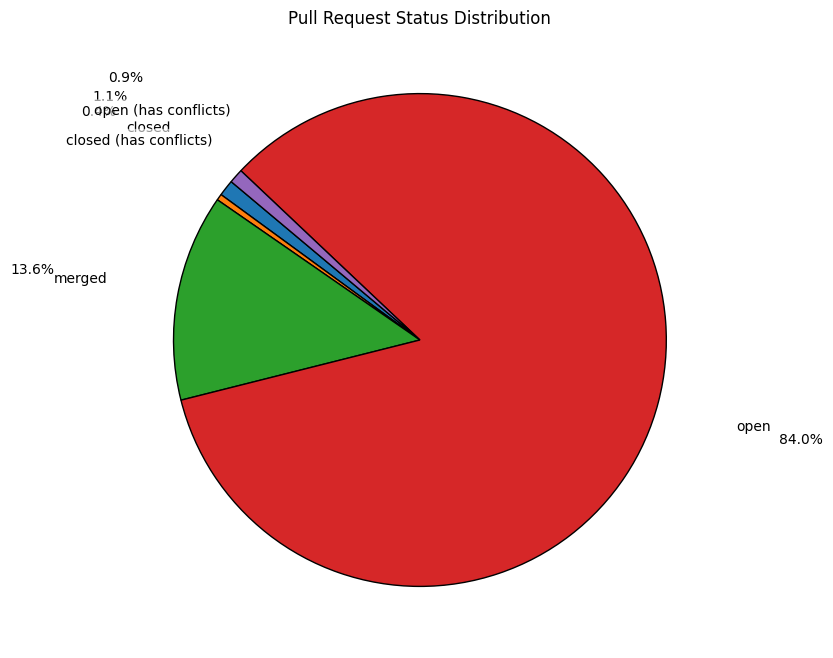

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the status distribution and convert to DataFrame
status_distribution = df['status'].value_counts().reset_index()
status_distribution.columns = ['status', 'count']

# Sort by status alphabetically, then by count
status_distribution = status_distribution.sort_values(by=['status', 'count'], ascending=[True, False])

# Convert back to Series for plotting
status_distribution = status_distribution.set_index('status')['count']

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts = ax.pie(
    status_distribution,
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
    startangle=140  # Optional: set starting angle for better orientation
)

# Add labels and percentages outside the pie chart
for i, (wedge, label) in enumerate(zip(wedges, status_distribution.index)):
    # Calculate angle for positioning
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    
    # Position label and percentage slightly further out to prevent overlap
    percentage = f"{status_distribution.iloc[i] / status_distribution.sum() * 100:.1f}%"
    
    # Annotate label
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(1.4 * x, 1.4 * y),  # Further out for labels
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.6)  # Background box for readability
    )
    
    # Annotate percentage
    ax.annotate(
        percentage,
        xy=(x, y),
        xytext=(1.6 * x, 1.6 * y),  # Further out for percentages
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

plt.title('Pull Request Status Distribution')
plt.show()


## Identify Relevant Discussions

Criteria:
PR has at least two non-empty comment.
PR has at least two different authors (not counting the SFConvertBot) engaging in the discussion.
The average comment size is more than 4 words.

In [81]:
from nb_utils import RESULTS_DIR
from tqdm import tqdm
import json

min_num_authors = 2
min_num_comments = 2
min_avg_comment_size = 0

output_file = RESULTS_DIR / 'sfconvertbot_pr_metadata_filtered.csv'
# create a dataframe to store the filtered PRs
df_filtered = pd.DataFrame(columns=df.columns)
# create lambda function that checks whether string.lower() == 'sfconvertbot'
is_sfconvertbot = lambda x: x.lower() == 'sfconvertbot'

# iterate over dataframe
for index, row in tqdm(df.iterrows(), total=len(df)):
    # parse as JSON (it should be a string)
    discussion = json.loads(row['discussion_metadata'])['discussion']
    # extract events and original author
    events = discussion['events']
    original_author = discussion['author']
    # criteria:
    num_words, num_non_empty_comments = 0, 0
    authors = set()
    if not is_sfconvertbot(original_author["name"]):
        authors.add(original_author["name"])

    for event in events:
        # print("\t",event)
        event_type = event['type']
        if event_type == 'comment' and not event['data']['hidden']:
            event_author = event['author']
            num_non_empty_comments += 1
            if not is_sfconvertbot(event_author["name"]):
                authors.add(event_author["name"])
            num_words += len(event['data']['latest']['raw'].split())

    should_include = (num_non_empty_comments >= min_num_comments and
                      len(authors) >= min_num_authors and
                      num_words / num_non_empty_comments >= min_avg_comment_size)
    # add the row to the filtered dataframe
    if should_include:
        df_filtered.loc[len(df_filtered)] = row
        title = f"{discussion['title']} by {original_author['name']} ({row['model_id']})"
        df_filtered.loc[len(df_filtered) - 1, 'title'] = title
        df_filtered.loc[len(df_filtered) - 1, 'num_comments'] = num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'num_authors'] = len(authors)
        df_filtered.loc[len(df_filtered) - 1, 'avg_comment_size'] = num_words / num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'authors'] = ";".join(authors)
        
# add a source column
df_filtered['source'] = 'SFConvertBot PRs'
# rename PR URL column to url
df_filtered.rename(columns={'pr_url': 'url'}, inplace=True)
# rename discussion_metadata to json_content
df_filtered.rename(columns={'discussion_metadata': 'json_content'}, inplace=True)
# reorder columns
df_filtered = df_filtered[['source', 'title', 'url', 'num_comments', 'num_authors', 'avg_comment_size', 'authors']]
# save the filtered dataframe
df_filtered.to_csv(output_file, index=True)
print("Number of PRs after filtering: ", len(df_filtered))
print("Saved to: ", output_file)